# Spotify Final Project - Emily Xie EDA
### Milestone 3: EDA and Baseline Model
### Austin Rochon, Emily Xie, and Mark Lock

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [2]:
%load_ext google.cloud.bigquery

In [3]:
%%bigquery playlist_data
SELECT * FROM `spotted-d.playlist_songs.playlists_songs_ordered_pid` LIMIT 500000;

In [9]:
len(playlist_data)

500000

## EDA ON PLAYLISTS

Let's first do some preliminary analysis on our playlists. The query above draws from a saved BigQuery table produced from a larger query that grabs 500,000 rows of joined song-playlist data which includes musical features and is grouped by playlists based on unique IDs.

To get a sense of the data, let's output a few rows:

In [17]:
playlist_data.head()

,unique_pid,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,index,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackid
0,999999,999,83,Colmillo Norteño,spotify:track:1VgBDN01P9evVutNs82GdY,spotify:artist:5YvrXxWXf9n9enAV8HHZSN,El Bueno y el Malo,spotify:album:6e03uUD8GyE7OTABd0fU53,Nueva Era,45.0,...,0.971,119.980,audio_features,1VgBDN01P9evVutNs82GdY,spotify:track:1VgBDN01P9evVutNs82GdY,https://api.spotify.com/v1/tracks/1VgBDN01P9ev...,https://api.spotify.com/v1/audio-analysis/1VgB...,176547.0,3.0,spotify:track:1VgBDN01P9evVutNs82GdY
1,999999,999,63,Julión Álvarez y su Norteño Banda,spotify:track:4HxK5Hmt3J5fxbSB6bpuQJ,spotify:artist:1bfl0AU8SqmLkElptOprhC,El Tomasín,spotify:album:24nwlfB4S80hyLZpCBaInA,El Aferrado,55.0,...,0.972,162.835,audio_features,4HxK5Hmt3J5fxbSB6bpuQJ,spotify:track:4HxK5Hmt3J5fxbSB6bpuQJ,https://api.spotify.com/v1/tracks/4HxK5Hmt3J5f...,https://api.spotify.com/v1/audio-analysis/4HxK...,161400.0,4.0,spotify:track:4HxK5Hmt3J5fxbSB6bpuQJ
2,999999,999,38,Regulo Caro,spotify:track:4doAczw4VqEa9qJu1M8Ou5,spotify:artist:0YRwUbRxrawmnBdixwJi5W,Empujando la Línea,spotify:album:1udzzVN47urH7cthUlyRMz,Especialista,47.0,...,0.920,109.942,audio_features,4doAczw4VqEa9qJu1M8Ou5,spotify:track:4doAczw4VqEa9qJu1M8Ou5,https://api.spotify.com/v1/tracks/4doAczw4VqEa...,https://api.spotify.com/v1/audio-analysis/4doA...,200493.0,3.0,spotify:track:4doAczw4VqEa9qJu1M8Ou5
3,999999,999,96,Marco Antonio Solís,spotify:track:4HAtRUbOtuIkvTSUhDr8sV,spotify:artist:3tJnB0s6c3oXPq1SCCavnd,La Venia Bendita,spotify:album:37pu7kgBbnw0AGTxhHVPOP,Marco Antonio Solis,24.0,...,0.507,152.257,audio_features,4HAtRUbOtuIkvTSUhDr8sV,spotify:track:4HAtRUbOtuIkvTSUhDr8sV,https://api.spotify.com/v1/tracks/4HAtRUbOtuIk...,https://api.spotify.com/v1/audio-analysis/4HAt...,191640.0,3.0,spotify:track:4HAtRUbOtuIkvTSUhDr8sV
4,999999,999,79,Martin Castillo,spotify:track:3QksQ49EJW6H1kWvyN05Wg,spotify:artist:7cTBwZEDfYdYu1ti31AgPw,"De Apatzingán, Michoacán",spotify:album:2u0VDTxkAwL2UvvEdM4OhL,Mundo de Ilusiones,95.0,...,0.965,118.891,audio_features,3QksQ49EJW6H1kWvyN05Wg,spotify:track:3QksQ49EJW6H1kWvyN05Wg,https://api.spotify.com/v1/tracks/3QksQ49EJW6H...,https://api.spotify.com/v1/audio-analysis/3Qks...,178627.0,3.0,spotify:track:3QksQ49EJW6H1kWvyN05Wg


As a simple analysis, let's see how many songs in each playlist:

In [58]:
average_songs = np.mean(playlist_data.groupby("unique_pid").count()["pos"])
print(f"The average playlist has: {average_songs} songs")

The average playlist has: 66.29541235746487 songs


With a distribution that looks like:

Text(0, 0.5, 'Number of Playlists')

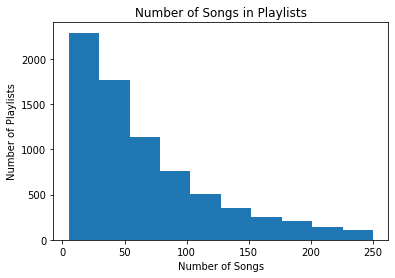

In [59]:
grouped_by_pid = playlist_data.groupby("unique_pid").count()
plt.hist(grouped_by_pid["pos"])
plt.title("Number of Songs in Playlists")
plt.xlabel("Number of Songs")
plt.ylabel("Number of Playlists")

Now, before we run any further analysis, let's make our feature data the musical properties of songs in a playlist. We'll standardize our data across these features.

In [60]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']

pids = playlist_data["unique_pid"]
playlist_data_ft = playlist_data[features]

scalar = MinMaxScaler().fit(playlist_data_ft)
playlists_transformed = scalar.transform(playlist_data_ft)
playlists_norm = pd.DataFrame(playlists_transformed, columns=features)
playlists_norm = pd.concat([pids, playlists_norm], axis = 1)

playlists_norm.head()

,unique_pid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,999999,0.814965,0.678,0.454545,0.860379,1.0,0.032746,0.553213,0.000014,0.2430,0.971,0.483642,0.031588,0.6
1,999999,0.769464,0.915,0.363636,0.871486,0.0,0.066321,0.135542,0.000017,0.1160,0.972,0.656392,0.028830,0.8
2,999999,0.748231,0.900,0.000000,0.870341,1.0,0.059689,0.169679,0.000000,0.1590,0.920,0.443179,0.035948,0.6
3,999999,0.522750,0.387,0.000000,0.817363,1.0,0.031710,0.157631,0.000000,0.3670,0.507,0.613751,0.034336,0.6
4,999999,0.839232,0.807,0.454545,0.848143,1.0,0.075648,0.219880,0.000155,0.0686,0.965,0.479252,0.031967,0.6


For starters, let's take at the average song features on a playlist level:

In [64]:
features_mean = {x: "mean" for x in features}

averaged_playlist_data = playlists_norm.groupby("unique_pid").agg(features_mean)
averaged_playlist_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
unique_pid,,,,,,,,,,,,,
991658,0.772497,0.743981,0.530303,0.830188,0.472222,0.121244,0.202630,0.274456,0.204288,0.731815,0.479493,0.042261,0.796296
991659,0.491860,0.343142,0.403030,0.766473,0.733333,0.051953,0.708099,0.018612,0.192778,0.490595,0.457902,0.032205,0.760000
991660,0.638726,0.678667,0.421212,0.854557,0.466667,0.148187,0.267395,0.000058,0.166393,0.520100,0.536134,0.039680,0.766667
991661,0.692072,0.662071,0.461967,0.845402,0.551020,0.130979,0.173855,0.008982,0.186014,0.578119,0.472090,0.041722,0.793878
991662,0.703425,0.662020,0.516630,0.843498,0.658537,0.223234,0.113785,0.005050,0.229354,0.450416,0.495933,0.044368,0.796098


With the features averaged together for a given playlist, let's use this data to compute the K-Means clusters at a playlist level.

In [90]:
"""
Note: From Austin's notebook. k-means implementation learned from University of 
Washington Coursera course in ML: https://www.coursera.org/specializations/machine-learning. 
Some code will be similar to course assignments.
"""
def compute_heterogeneity(num_clusters, df):
    '''Computes KMeans and saves score for each run'''
    kmeans = []
    score = []
    
    for i in num_clusters:
        print(f"""\n================================================"""
              f"""\nComputing KMeans for {i} cluster(s)"""
              f"""\n================================================""")
        
        kmeans.append(KMeans(n_clusters=i))
        score.append(kmeans[i - 1].fit(df).score(df))
        
        print(f"""Heterogeneity: {score[i-1]}""")
        
    return score

def kmeans(num_clusters, data):
    '''Runs kmeans algorithm, returning cluster assignment and centers'''
    # Initialize KMeans
    kmeans = KMeans(n_clusters=num_clusters)

    # Fitting with inputs
    kmeans = kmeans.fit(data)

    # Predicting clusters
    labels = kmeans.predict(data)

    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    return labels, centers

def build_kmeans_output(data, col_name):
    # Builds out final dataset
    df_means[col_name] = data.groupby(['cluster'])[col_name].mean().to_frame(col_name)    
    
def run_kmeans(df, clusters):
    # Run kmeans, given a specified number of clusters
    data = df.copy()
    labels, centers = kmeans(clusters, data.drop("unique_pid", axis=1))
    data['cluster'] = labels
    
    # Build df_means table to store results
    df_means = data.groupby(['cluster'])['unique_pid'].count().to_frame('n')
    
    for col in data.columns.values:
        if col != 'unique_pid':
            df_means[col] = data.groupby(['cluster'])[col].mean().to_frame(col)    
      
    # Generate alphabetical representation of clusters
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10:"K", 11:"L", 12:"M", 13:"N", 14:"O"}
    df_means['cluster_alpha'] = df_means['cluster']
    df_means = df_means.replace({'cluster_alpha':mapping})

    data['cluster_alpha'] = data['cluster']
    data = data.replace({'cluster_alpha':mapping})
    
    return df_means, data

def plot_bar_by_cluster(df, cols):
    sns.set(style="whitegrid")

    # Draw a nested barplot 
    chart = sns.catplot(x=cols[0], y=cols[1], data=df[cols],
                    height=6, kind="bar", palette="Blues_r")
    chart.despine(left=True)
    chart.set_ylabels(cols[1])
    chart.set_xlabels(cols[0])
    plt.title(f"""Mean {cols[1]} by cluster"""); 


Computing KMeans for 1 cluster(s)
Heterogeneity: -950.3257370037662

Computing KMeans for 2 cluster(s)
Heterogeneity: -649.960572227114

Computing KMeans for 3 cluster(s)
Heterogeneity: -548.8318117556921

Computing KMeans for 4 cluster(s)
Heterogeneity: -469.20858000432503

Computing KMeans for 5 cluster(s)
Heterogeneity: -428.55142445497904

Computing KMeans for 6 cluster(s)
Heterogeneity: -394.4814948042559

Computing KMeans for 7 cluster(s)
Heterogeneity: -368.48938287599753

Computing KMeans for 8 cluster(s)
Heterogeneity: -346.4654777837427

Computing KMeans for 9 cluster(s)
Heterogeneity: -326.6173260751689

Computing KMeans for 10 cluster(s)
Heterogeneity: -310.9194936913621

Computing KMeans for 11 cluster(s)
Heterogeneity: -299.63272470971435

Computing KMeans for 12 cluster(s)
Heterogeneity: -289.02397459915403

Computing KMeans for 13 cluster(s)
Heterogeneity: -279.3661065562524

Computing KMeans for 14 cluster(s)
Heterogeneity: -270.9664229637741

Computing KMeans for 15 

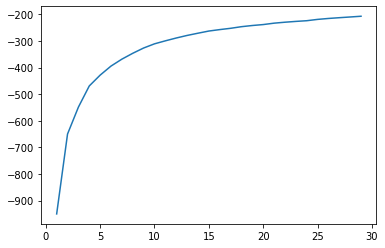

In [72]:
num_clusters = range(1,30)
score = compute_heterogeneity(num_clusters, averaged_playlist_data)

# Build "elbow graph"
plt.plot(num_clusters, score)

Looking at the "elbow graph", a noticeble bend starts happening at around 7, but taking more categories would make sense as there are many categories of playlists out there; let's grab 15, as that lies on the outer edges of what seems reasonable.

In [91]:
k = 15
averaged_playlist_data["unique_pid"] = averaged_playlist_data.index
average_playlist_means, playlist_clusters = run_kmeans(averaged_playlist_data, k)
average_playlist_means

,n,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,cluster_alpha
cluster,,,,,,,,,,,,,,,,
0,550,0.731331,0.719893,0.497119,0.839508,0.543674,0.129080,0.166683,0.022867,0.190329,0.690850,0.475295,0.043147,0.796664,0,A
1,352,0.632283,0.593445,0.473893,0.806612,0.803915,0.063175,0.385508,0.032333,0.182439,0.698734,0.494111,0.038564,0.770641,1,B
2,1038,0.651010,0.724988,0.462979,0.849578,0.635942,0.101129,0.131736,0.024806,0.194871,0.551251,0.491591,0.041110,0.796424,2,C
3,112,0.514940,0.475436,0.462731,0.754276,0.602044,0.066401,0.468670,0.499043,0.179239,0.339252,0.464482,0.048534,0.772597,3,D
4,1016,0.724812,0.623462,0.463127,0.835376,0.577342,0.191278,0.160973,0.007894,0.191043,0.443129,0.496778,0.040949,0.797064,4,E
5,755,0.581146,0.728371,0.468280,0.838648,0.822454,0.062023,0.156321,0.028028,0.187937,0.580378,0.503094,0.041261,0.793449,5,F
6,449,0.605355,0.540072,0.480247,0.812886,0.496307,0.099988,0.330013,0.054028,0.171505,0.395449,0.473289,0.042948,0.785391,6,G
7,600,0.664075,0.702078,0.492290,0.847676,0.436236,0.116832,0.139245,0.031955,0.194329,0.489486,0.488547,0.041424,0.796865,7,H
8,251,0.630094,0.743924,0.489572,0.836642,0.509392,0.085852,0.109559,0.310949,0.201450,0.422388,0.504805,0.048204,0.792476,8,I


So now, we have 15 clusters.

In [86]:
averaged_playlist_data

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,unique_pid
unique_pid,,,,,,,,,,,,,,
991658,0.772497,0.743981,0.530303,0.830188,0.472222,0.121244,0.202630,2.744563e-01,0.204288,0.731815,0.479493,0.042261,0.796296,991658
991659,0.491860,0.343142,0.403030,0.766473,0.733333,0.051953,0.708099,1.861243e-02,0.192778,0.490595,0.457902,0.032205,0.760000,991659
991660,0.638726,0.678667,0.421212,0.854557,0.466667,0.148187,0.267395,5.818500e-05,0.166393,0.520100,0.536134,0.039680,0.766667,991660
991661,0.692072,0.662071,0.461967,0.845402,0.551020,0.130979,0.173855,8.982398e-03,0.186014,0.578119,0.472090,0.041722,0.793878,991661
991662,0.703425,0.662020,0.516630,0.843498,0.658537,0.223234,0.113785,5.050486e-03,0.229354,0.450416,0.495933,0.044368,0.796098,991662
991663,0.750080,0.711220,0.529933,0.802076,0.658537,0.082682,0.034788,6.944722e-01,0.156756,0.316276,0.507321,0.075804,0.795122,991663
991664,0.578297,0.579532,0.419355,0.821864,0.241935,0.094215,0.235471,2.979887e-03,0.177589,0.333411,0.512504,0.049389,0.796774,991664
991665,0.463928,0.358770,0.429545,0.787964,0.550000,0.048047,0.630851,8.885609e-02,0.117922,0.238945,0.488080,0.042867,0.770000,991665
991666,0.732272,0.568710,0.534914,0.825238,0.550725,0.215613,0.272839,1.971886e-03,0.178443,0.433246,0.493901,0.040984,0.788406,991666


In [76]:
for feature in features:
    cols = ["cluster"]
    cols.append(feature)
    plot_bar_by_cluster(playlist_means, cols)

NameError: name 'playlist_means' is not defined

## EDA

In [10]:
playlist_data.head()

,unique_pid,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,index,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackid
0,999999,999,83,Colmillo Norteño,spotify:track:1VgBDN01P9evVutNs82GdY,spotify:artist:5YvrXxWXf9n9enAV8HHZSN,El Bueno y el Malo,spotify:album:6e03uUD8GyE7OTABd0fU53,Nueva Era,45.0,...,0.971,119.980,audio_features,1VgBDN01P9evVutNs82GdY,spotify:track:1VgBDN01P9evVutNs82GdY,https://api.spotify.com/v1/tracks/1VgBDN01P9ev...,https://api.spotify.com/v1/audio-analysis/1VgB...,176547.0,3.0,spotify:track:1VgBDN01P9evVutNs82GdY
1,999999,999,63,Julión Álvarez y su Norteño Banda,spotify:track:4HxK5Hmt3J5fxbSB6bpuQJ,spotify:artist:1bfl0AU8SqmLkElptOprhC,El Tomasín,spotify:album:24nwlfB4S80hyLZpCBaInA,El Aferrado,55.0,...,0.972,162.835,audio_features,4HxK5Hmt3J5fxbSB6bpuQJ,spotify:track:4HxK5Hmt3J5fxbSB6bpuQJ,https://api.spotify.com/v1/tracks/4HxK5Hmt3J5f...,https://api.spotify.com/v1/audio-analysis/4HxK...,161400.0,4.0,spotify:track:4HxK5Hmt3J5fxbSB6bpuQJ
2,999999,999,38,Regulo Caro,spotify:track:4doAczw4VqEa9qJu1M8Ou5,spotify:artist:0YRwUbRxrawmnBdixwJi5W,Empujando la Línea,spotify:album:1udzzVN47urH7cthUlyRMz,Especialista,47.0,...,0.920,109.942,audio_features,4doAczw4VqEa9qJu1M8Ou5,spotify:track:4doAczw4VqEa9qJu1M8Ou5,https://api.spotify.com/v1/tracks/4doAczw4VqEa...,https://api.spotify.com/v1/audio-analysis/4doA...,200493.0,3.0,spotify:track:4doAczw4VqEa9qJu1M8Ou5
3,999999,999,96,Marco Antonio Solís,spotify:track:4HAtRUbOtuIkvTSUhDr8sV,spotify:artist:3tJnB0s6c3oXPq1SCCavnd,La Venia Bendita,spotify:album:37pu7kgBbnw0AGTxhHVPOP,Marco Antonio Solis,24.0,...,0.507,152.257,audio_features,4HAtRUbOtuIkvTSUhDr8sV,spotify:track:4HAtRUbOtuIkvTSUhDr8sV,https://api.spotify.com/v1/tracks/4HAtRUbOtuIk...,https://api.spotify.com/v1/audio-analysis/4HAt...,191640.0,3.0,spotify:track:4HAtRUbOtuIkvTSUhDr8sV
4,999999,999,79,Martin Castillo,spotify:track:3QksQ49EJW6H1kWvyN05Wg,spotify:artist:7cTBwZEDfYdYu1ti31AgPw,"De Apatzingán, Michoacán",spotify:album:2u0VDTxkAwL2UvvEdM4OhL,Mundo de Ilusiones,95.0,...,0.965,118.891,audio_features,3QksQ49EJW6H1kWvyN05Wg,spotify:track:3QksQ49EJW6H1kWvyN05Wg,https://api.spotify.com/v1/tracks/3QksQ49EJW6H...,https://api.spotify.com/v1/audio-analysis/3Qks...,178627.0,3.0,spotify:track:3QksQ49EJW6H1kWvyN05Wg


In [11]:
playlist_data.dtypes

unique_pid            int64
pid                   int64
pos                   int64
artist_name          object
track_uri            object
artist_uri           object
track_name           object
album_uri            object
album_name           object
index               float64
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms         float64
time_signature      float64
trackid              object
dtype: object

Most popular tracks

In [ ]:
counts_by_track = playlist_data.groupby(["trackid", "track_name", "artist_name"]).count()
counts_by_track["count_freq"] = counts_by_track["unique_pid"]
counts_by_track[["count_freq"]].sort_values(by="count_freq", ascending=False)

In [ ]:
sns.set(color_codes=False)
sns.distplot(counts_by_track[["count_freq"]], kde=False);

Now, let's start examining our acoustic data

In [ ]:
# https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
playlist_numeric = playlist_data.select_dtypes(include=numerics)
playlist_numeric["trackid"] = playlist_data["trackid"]
playlist_numeric = playlist_numeric.set_index("trackid")
playlist_numeric.head()

In [ ]:
# drop our trivial numeric data
playlist_numeric = playlist_numeric.drop(["index","pid", "pos"], axis=1)

In [ ]:
# Correlation matrix
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set_style("whitegrid", {'axes.grid' : False})

# Compute the correlation matrix
corr = playlist_numeric.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set up labels
plt.xlabel("Audio Feature")
plt.ylabel("Audio Feature")
plt.title("Correlogram of Audio Features")
plt.show()

In [ ]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Pairplot
pp = sns.pairplot(playlist_numeric.sample(frac=0.05)[["danceability", "energy", "loudness", "speechiness", "valence"]])

# # Set up labels
# plt.xlabel("Audio Feature")
# plt.ylabel("Audio Feature")
# plt.title("Pairwise Relationships Between Select Audio Features");

## Baseline Model

#### K-Means for labeling

Okay, let's try to group these songs into clusters, using their audio properties. First, we need to normalize our data

In [ ]:
def normalize(df, scalar, features):
    # Split df into features and non-features
    non_feature_df = df[df.columns.difference(features)]
    feature_df = df[features]
    
    # Scale the features
    np_transform = scalar.transform(feature_df)
    df_transform = pd.DataFrame(np_transform, columns=features)

    # Merge back the features and non-features
    non_feature_df.reset_index(drop=True, inplace=True)
    df_transform.reset_index(drop=True, inplace=True)
    df_transform = pd.concat([non_feature_df, df_transform], axis = 1)
    
    return df_transform

In [ ]:
scalar = MinMaxScaler().fit(playlist_numeric)
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']

In [ ]:
playlist_norm = normalize(playlist_numeric, scalar, features)
playlist_norm["trackid"] = playlist_numeric.index
playlist_norm = playlist_norm.set_index("trackid")

In [ ]:
display(playlist_numeric.head())
display(playlist_norm.head())


We have a couple NAs, let's drop them

In [ ]:
playlist_norm.isna().sum()

In [ ]:
playlist_norm = playlist_norm.dropna(how="all")

#### Compute heterogeneity and build "elbow" graph to optimze k
Note: k-means implementation learned from University of Washington Coursera course in ML: https://www.coursera.org/specializations/machine-learning. Some code will be similar to course assignments.

In [62]:
def compute_heterogeneity(num_clusters, df):
    '''Computes KMeans and saves score for each run'''
    kmeans = []
    score = []
    
    for i in num_clusters:
        print(f"""\n================================================"""
              f"""\nComputing KMeans for {i} cluster(s)"""
              f"""\n================================================""")
        
        kmeans.append(KMeans(n_clusters=i))
        score.append(kmeans[i - 1].fit(df).score(df))
        
        print(f"""Heterogeneity: {score[i-1]}""")
        
    return score

In [ ]:
num_clusters = range(1,10)
score = compute_heterogeneity(num_clusters, playlist_norm)

plt.plot(num_clusters, score)

The ideal number of clusters, k, appears to be either 2 or 4, based on the elbow chart. Let's choose 4 to have more groups to segment our data

#### Run k-means with chosen number of clusters

In [66]:
def kmeans(num_clusters, data):
    '''Runs kmeans algorithm, returning cluster assignment and centers'''
    # Initialize KMeans
    kmeans = KMeans(n_clusters=num_clusters)

    # Fitting with inputs
    kmeans = kmeans.fit(data)

    # Predicting clusters
    labels = kmeans.predict(data)

    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    return labels, centers

In [ ]:
def build_kmeans_output(data, col_name):
    '''Builds out final dataset'''
    df_means[col_name] = data.groupby(['cluster'])[col_name].mean().to_frame(col_name)    

In [ ]:
def run_kmeans(df, clusters):
    # Run kmeans, given a specified number of clusters
    data = df.copy()
    labels, centers = kmeans(clusters, data.drop("trackid", axis=1))
    data['cluster'] = labels
    
    # Build df_means table to store results
    df_means = data.groupby(['cluster'])['trackid'].count().to_frame('n')
    
    for col in data.columns.values:
        if col != 'trackid':
            df_means[col] = data.groupby(['cluster'])[col].mean().to_frame(col)    
      
    # Generate alphabetical representation of clusters
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'K'}
    df_means['cluster_alpha'] = df_means['cluster']
    df_means = df_means.replace({'cluster_alpha':mapping})

    data['cluster_alpha'] = data['cluster']
    data = data.replace({'cluster_alpha':mapping})
    
    return df_means, data

In [ ]:
k = 10
playlist_norm["trackid"] = playlist_norm.index
playlist_means, playlist_clusters = run_kmeans(playlist_norm, k)
playlist_means

In [ ]:
playlist_clusters.head()

#### Visualize attributes across clusters

In [ ]:
def plot_bar_by_cluster(df, cols):
    sns.set(style="whitegrid")

    # Draw a nested barplot 
    chart = sns.catplot(x=cols[0], y=cols[1], data=df[cols],
                    height=6, kind="bar", palette="Blues_r")
    chart.despine(left=True)
    chart.set_ylabels(cols[1])
    chart.set_xlabels(cols[0])
    plt.title(f"""Mean {cols[1]} by cluster"""); 

In [ ]:
features = ['n','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
           'duration_ms', 'time_signature']

for feature in features:
    cols = ["cluster"]
    cols.append(feature)
    plot_bar_by_cluster(playlist_means, cols)

In [ ]:
writeup_features = ['n', 'duration_ms', 'instrumentalness', 'acousticness', 'key']

for feature in writeup_features:
    cols = ["cluster"]
    cols.append(feature)
    plot_bar_by_cluster(playlist_means, cols)

#### K-Nearest Neighbors

Great, now that we have labels for our tracks (cluster number), we can build a recommender engine. Let's use K-Nearest neighbors to fit future songs to a given cluster. First, we need to split our data into train and test.

In [ ]:
playlist_clusters = playlist_clusters.drop(["trackid", "cluster"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(playlist_clusters.loc[:, playlist_clusters.columns != 'cluster_alpha'], 
                                                    playlist_clusters.cluster_alpha, test_size=0.2, 
                                                    random_state = 666, 
                                                    stratify = playlist_clusters.cluster_alpha)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Now, train our knn model using Cross-Validation

In [ ]:
ks = [2, 5, 7, 10, 20, 25, 50, 100]
output = []

for k in ks:
    # https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a
    print(f'''**************************************'''
          f'''\nRunning kNN classification for k={k}''')
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5)
    output.append({"k": k, "cv_scores_mean": np.mean(cv_scores)})
    print(f'''cv_scores: {cv_scores}''')
    print(f'''cv_scores mean: {np.mean(cv_scores)}''')


In [ ]:
pd.DataFrame(output)

In [ ]:
# Idk.. let's choose 7?
knn_chosen = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
knn_chosen_predictions_train = knn_chosen.predict(X_train)
knn_chosen_predictions_test = knn_chosen.predict(X_test)

In [ ]:
def report_accuracy_and_misclassification(y_train, y_test, predictions_train, predictions_test):
    print(f'''Accuracy score on training data: '''
          f'''{accuracy_score(y_train, predictions_train)}''')

    print(f'''Misclassification rate on training data: '''
          f'''{1 - accuracy_score(y_train, predictions_train)}''')

    print(f'''Accuracy score on test data: '''
          f'''{accuracy_score(y_test, predictions_test)}''')

    print(f'''Misclassification rate on test data: '''
          f'''{1 - accuracy_score(y_test, predictions_test)}''')
            

In [ ]:
report_accuracy_and_misclassification(y_train, 
                                      y_test, 
                                      knn_chosen_predictions_train, 
                                      knn_chosen_predictions_test)

#### Make Predictions With K-Nearest Neighbors
Now that we have a model, selected using cross-validation, we can predict class labels. Can we also get closest song? Return a list of *n* closest songs in terms of feature vector distance